Environment

In [ ]:
!git clone https://github.com/spotify/basic-pitch.git

In [ ]:
%cd /content/basic-pitch

In [ ]:
!sudo apt-get update -y
!sudo apt-get install python3.10 python3.10-distutils python3.10-venv -y

In [ ]:
!python3.10 -m venv py310

In [ ]:
!py310/bin/pip install --upgrade pip
!py310/bin/pip install basic-pitch

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!mkdir -p /content/output

In [ ]:
!py310/bin/pip install "numpy<2"
!py310/bin/pip install basic-pitch[tf]

# Separate audio tracks

In [ ]:
!pip install demucs


In [ ]:
!demucs --mp3 -n htdemucs "/content/basic-pitch/Vinzenz-Cat-Jump.wav"

# Transform

In [ ]:
!apt-get update
!apt-get install -y ffmpeg
!pip install pydub

In [ ]:
import os, glob, shutil, subprocess
import ipywidgets as widgets
from IPython.display import display
from pydub import AudioSegment

stems_folder = "/content/basic-pitch/separated/htdemucs/Vinzenz-Cat-Jump"
basicpitch_out = "/content/output"
basicpitch_bin = "py310/bin/basic-pitch"

VALID_STEMS = ["bass", "drums", "other", "vocals"]

def find_stem_file(stems_folder: str, stem: str) -> str:
    if stem not in VALID_STEMS:
        raise ValueError(f"stem must be one of {VALID_STEMS}, got: {stem}")

    exts = ["wav", "mp3", "flac", "m4a", "ogg"]
    candidates = []
    for ext in exts:
        candidates += glob.glob(os.path.join(stems_folder, f"{stem}.{ext}"))
    if candidates:
        order = {".wav": 0, ".flac": 1, ".m4a": 2, ".ogg": 3, ".mp3": 4}
        candidates.sort(key=lambda p: order.get(os.path.splitext(p)[1].lower(), 99))
        return candidates[0]

    fuzzy = []
    for ext in exts:
        fuzzy += glob.glob(os.path.join(stems_folder, f"*{stem}*.{ext}"))
    if not fuzzy:
        raise FileNotFoundError(f"No file found for stem '{stem}' in: {stems_folder}")

    order = {".wav": 0, ".flac": 1, ".m4a": 2, ".ogg": 3, ".mp3": 4}
    fuzzy.sort(key=lambda p: order.get(os.path.splitext(p)[1].lower(), 99))
    return fuzzy[0]

def ensure_wav(input_path: str, wav_path: str, sample_rate=44100, channels=1) -> str:
    ext = os.path.splitext(input_path)[1].lower()
    os.makedirs(os.path.dirname(wav_path), exist_ok=True)

    if ext == ".wav":
        if os.path.abspath(input_path) != os.path.abspath(wav_path):
            shutil.copy2(input_path, wav_path)
        return wav_path

    audio = AudioSegment.from_file(input_path)
    audio = audio.set_frame_rate(sample_rate).set_channels(channels)
    audio.export(wav_path, format="wav")
    return wav_path

def stem_to_wav(stems_folder: str, stem: str) -> str:
    stem_file = find_stem_file(stems_folder, stem)
    wav_dir = os.path.join(stems_folder, "wav")
    wav_path = os.path.join(wav_dir, f"{stem}.wav")
    ensure_wav(stem_file, wav_path, sample_rate=44100, channels=1)
    return wav_path

def find_latest_midi(out_dir: str) -> str | None:
    mids = glob.glob(os.path.join(out_dir, "*.mid")) + glob.glob(os.path.join(out_dir, "*.midi"))
    if not mids:
        return None
    mids.sort(key=os.path.getmtime, reverse=True)
    return mids[0]

out = widgets.Output()
stem_dropdown = widgets.Dropdown(
    options=VALID_STEMS,
    value="bass",
    description="Instrument:",
    layout=widgets.Layout(width="420px")
)

_is_running = False

def run_pipeline_for_stem(stem: str):
    global _is_running
    if _is_running:
        return
    _is_running = True

    with out:
        out.clear_output()
        print("Selected stem:", stem)

        try:
            wav_path = stem_to_wav(stems_folder, stem)
            print("[OK] WAV generated:", wav_path)
        except Exception as e:
            print("[ERROR] WAV step failed:", repr(e))
            _is_running = False
            return

        try:
            os.makedirs(basicpitch_out, exist_ok=True)
            print("Running basic-pitch:")
            print(f"!{basicpitch_bin} {basicpitch_out} {wav_path}")

            subprocess.run([basicpitch_bin, basicpitch_out, wav_path], check=True)

            latest_midi = find_latest_midi(basicpitch_out)
            if latest_midi:
                print("[DONE] Latest MIDI:", latest_midi)
            else:
                print("[DONE] basic-pitch finished, but no MIDI found in:", basicpitch_out)

        except Exception as e:
            print("[ERROR] basic-pitch failed:", repr(e))

    _is_running = False

def on_stem_change(change):
    if change["name"] == "value" and change["type"] == "change":
        run_pipeline_for_stem(change["new"])

stem_dropdown.observe(on_stem_change, names="value")

display(stem_dropdown, out)

run_pipeline_for_stem(stem_dropdown.value)


# Show Score

In [ ]:
!pip install -q music21 verovio

In [ ]:
import os, glob

def find_latest_midi(output_dir: str) -> str:
    mids = glob.glob(os.path.join(output_dir, "*.mid")) + glob.glob(os.path.join(output_dir, "*.midi"))
    if not mids:
        raise FileNotFoundError(f"No MIDI found in: {output_dir}")
    mids.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return mids[0]


In [ ]:
from music21 import converter
import verovio
from IPython.display import SVG

def midi_to_svg(midi_path: str, page: int = 1):
    s = converter.parse(midi_path)
    musicxml_path = s.write('musicxml')

    with open(musicxml_path, 'r', encoding='utf-8') as f:
        mxl_data = f.read()

    toolkit = verovio.toolkit()
    toolkit.loadData(mxl_data)

    svg = toolkit.renderToSVG(page)
    return SVG(svg), musicxml_path


Auto-selected MIDI: /content/output/drums_basic_pitch.mid
Generated MusicXML: /tmp/music21/tmp52w885gd.musicxml


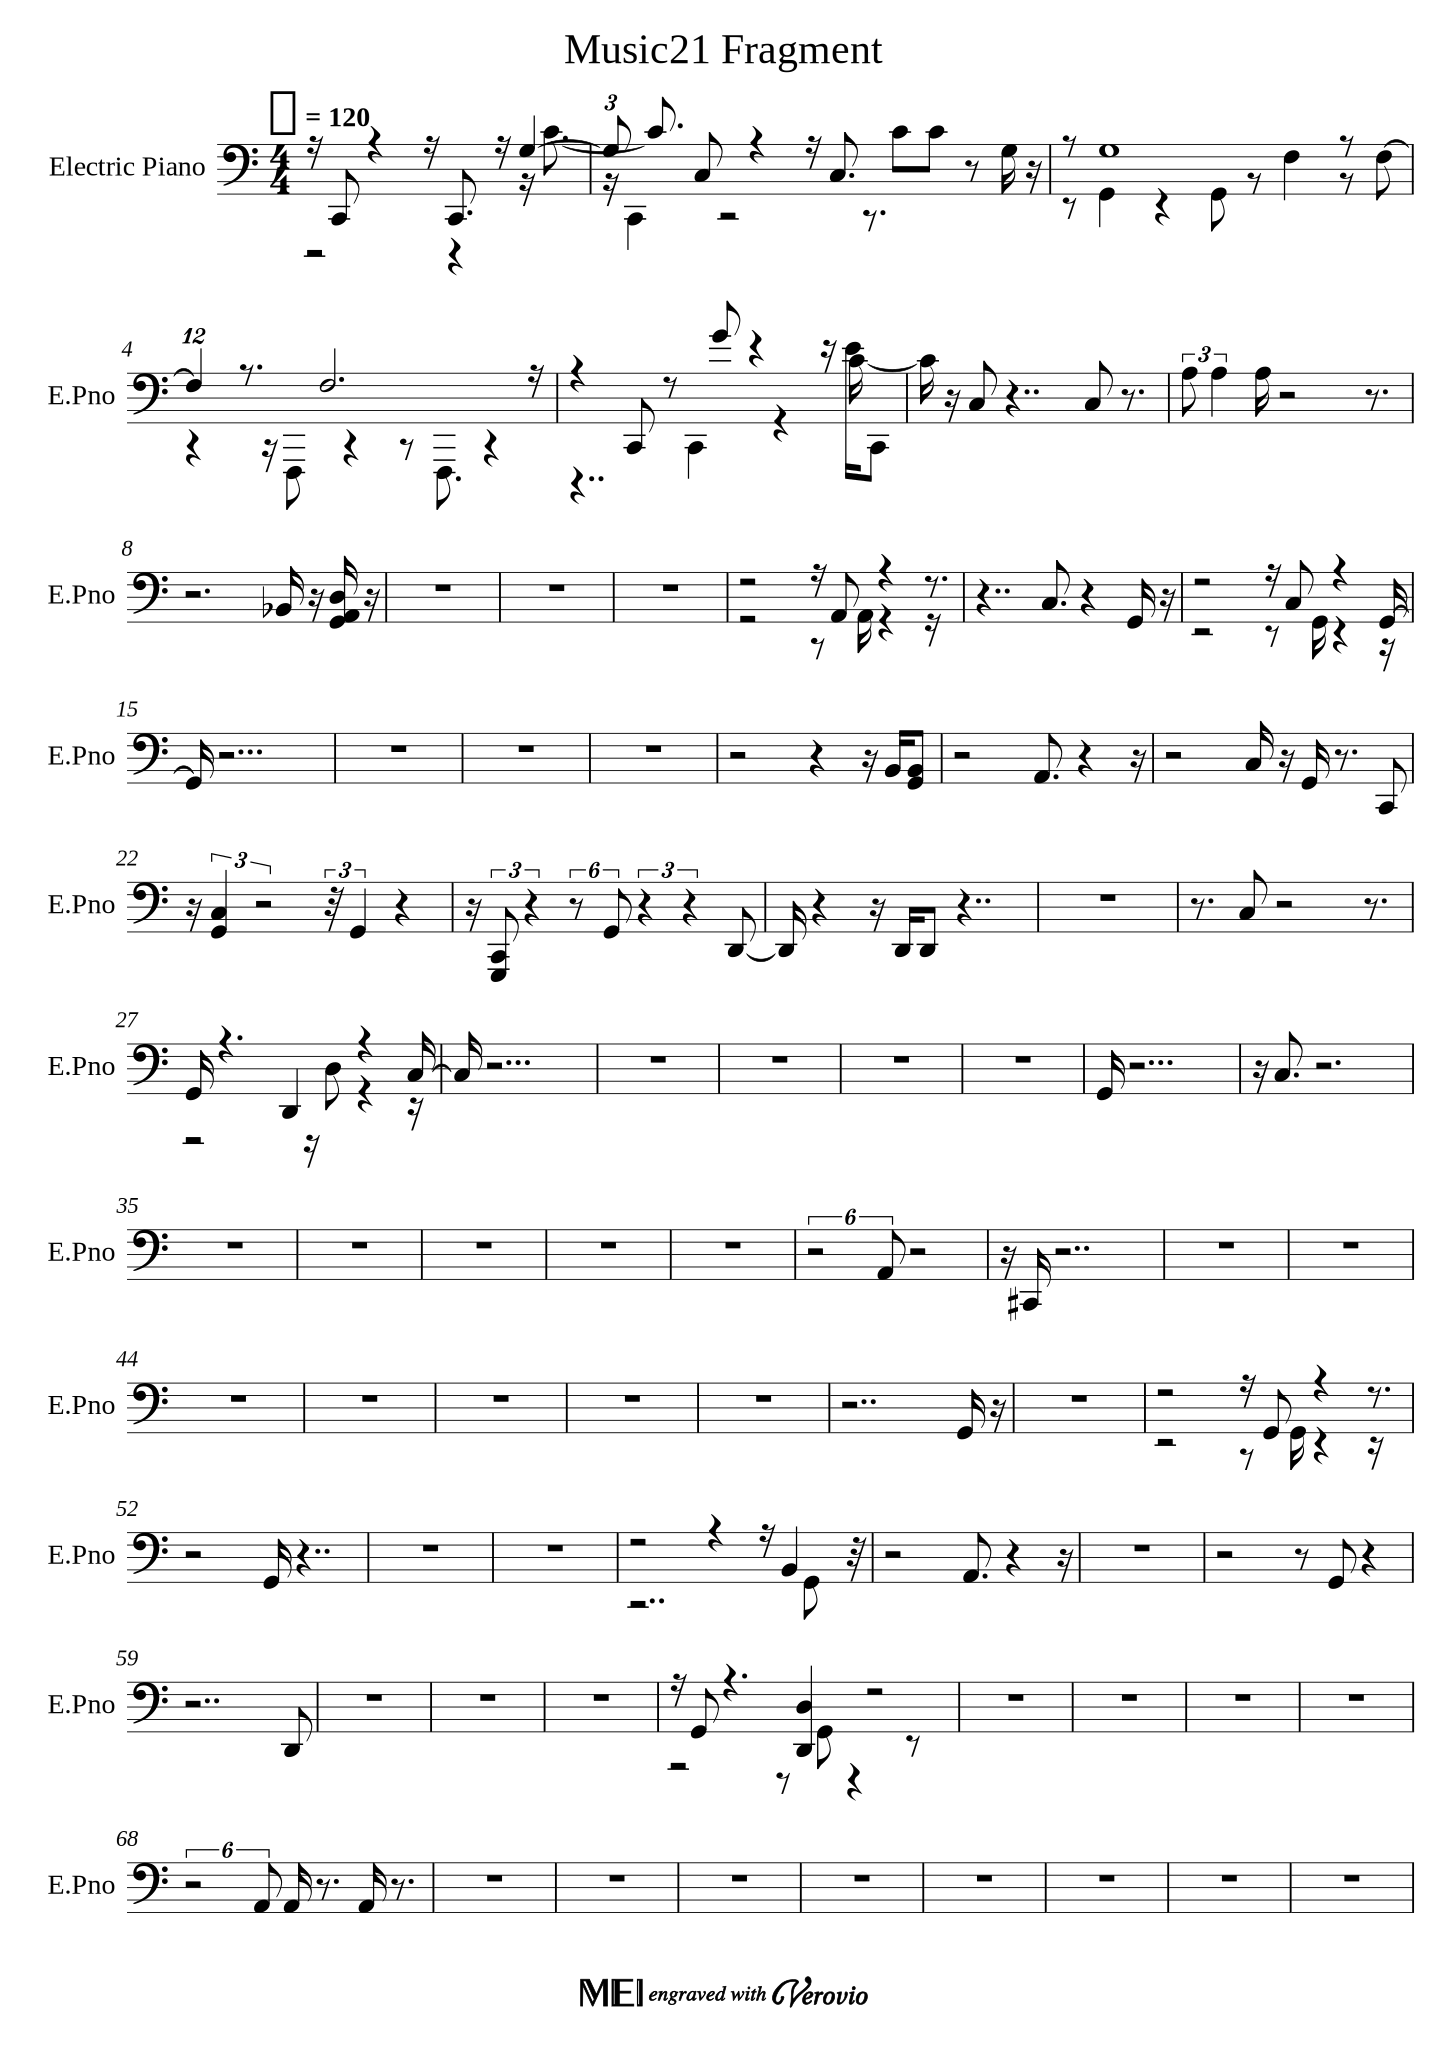

In [50]:
midi_path = find_latest_midi(basicpitch_out)
print("Auto-selected MIDI:", midi_path)

svg_obj, musicxml_path = midi_to_svg(midi_path, page=1)
print("Generated MusicXML:", musicxml_path)

svg_obj


In [51]:
import os, zipfile
import verovio
from google.colab import files

def export_full_score_svgs(musicxml_path: str, out_dir: str = "/content/score_svgs", max_pages: int = 200):
    os.makedirs(out_dir, exist_ok=True)

    with open(musicxml_path, "r", encoding="utf-8") as f:
        mxl_data = f.read()

    tk = verovio.toolkit()
    tk.loadData(mxl_data)

    page = 1
    saved = []

    while page <= max_pages:
        svg = tk.renderToSVG(page)

        if not svg or len(svg.strip()) < 200:
            break

        svg_path = os.path.join(out_dir, f"page_{page:03d}.svg")
        with open(svg_path, "w", encoding="utf-8") as f:
            f.write(svg)

        saved.append(svg_path)
        page += 1

    return saved, out_dir

def zip_folder(folder_path: str, zip_path: str):
    with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
        for root, _, filenames in os.walk(folder_path):
            for fn in filenames:
                full = os.path.join(root, fn)
                rel = os.path.relpath(full, folder_path)
                zf.write(full, rel)

print("MusicXML (full score) path:", musicxml_path)

svg_files, out_dir = export_full_score_svgs(musicxml_path, out_dir="/content/full_score_svgs")
print(f"Exported {len(svg_files)} SVG pages to:", out_dir)

zip_path = "/content/full_score_svgs.zip"
zip_folder(out_dir, zip_path)
print("Zipped SVG pages:", zip_path)

files.download(zip_path)

MusicXML (full score) path: /tmp/music21/tmp52w885gd.musicxml
Exported 200 SVG pages to: /content/full_score_svgs
Zipped SVG pages: /content/full_score_svgs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>